In [6]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:90%;}
div.CodeMirror {font-family:Consolas; font-size:18pt;}
div.output {font-size:19pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # 훈련데이터셋과 테스트셋을 분리
from tensorflow.keras.models import Sequential # 모델생성
from tensorflow.keras.layers import Dense,Dropout,Input #Dense(모델 layer). Dropout(과적합)
import matplotlib.pyplot as plt
from tensorflow.keras import metrics # 성능지표들

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

- 심장병 발병 예측
```
1. 데이터 셋생성 & 전처리
    엑셀데이터 -> ?를 nan -> nan처리 -> X,y분리 ->X 스케일 조정 -> 훈련셋과 테스트셋 분리(api이용)
2. 모델 생성 & 구성(과적합 줄이기 단계 추가)
3. 학습과정설정(accuracy, precision, recall)
4. 모델 학습 시키기 (훈련셋의 일부를 검증셋으로 학습)
5. 모델평가 - 과정살펴보기(그래프), evaluate, pd.crosstab/confusion_matrix(혼돈행렬)
6. 모델 사용하기

#age - 나이
#sex - (1 = 남성; 0 = 여성)
#cp - 가슴 통증 유형(0, 1, 2, 3, 4)
#trestbps - 안정 혈압(병원 입원시 mm Hg)
#chol - 혈청 콜레스테롤(mg/dl)
#fbs - (공복 혈당 > 120 mg/dl)(1 = true; 0 = false)
#restecg - 안정 심전도 결과(0, 1, 2)
#thalach - 최대 심박동수
#exang - 협심증 유발 운동(1 = yes; 0 = no)
#oldpeak - 비교적 안정되기까지 운동으로 유발되는 ST depression
#slope - 최대 운동 ST segment의 기울기
#ca - 형광 투시된 주요 혈관의 수(0-3)
#thal - (3 = 보통; 6 = 해결된 결함; 7 = 해결가능한 결함)
#target - 심장병 진단(1 = true; 0 = false)
```

# 1. 데이터 셋생성 & 전처리
    * 엑셀데이터 -> ?를 nan -> nan처리 -> X,y분리 ->X 스케일 조정 -> 훈련셋과 테스트셋 분리(api이용)

In [8]:
raw_data = pd.read_excel('./data/heart-disease.xlsx')
raw_data

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,0,108,1,1.5,2,3,3,1
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7,1
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7,1
301,57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [17]:
# raw_data 의 타입이 object인 열에 ?가 있는 데이터 추출
raw_data[(raw_data['chol']=='?')| (raw_data['ca']=='?') | (raw_data['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [21]:
#'?'를 결측치(np.nan)로 대체
clean_data = raw_data.replace('?',np.nan)
clean_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [26]:
# clean_data 에 결측치가 포함된 데이터 추출
clean_data[clean_data.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [29]:
# 결측치를 중앙값으로 대체 
# clean_data.median(axis=0) - axis=0은 기본값이므로 생략 가능
clean_data.fillna(value = clean_data.median())

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,241.5,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264.0,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193.0,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131.0,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236.0,0,2,174,0,0.0,2,1.0,3.0,1


In [31]:
#결측치가 하나라도 있는 행은 제거
clean_data.dropna(how='any',inplace=True)
clean_data.isnull().sum()


age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [33]:
clean_data.head()

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236.0,0,0,178,0,0.8,1,0.0,3.0,0


In [49]:
# 독립변수(입력변수,x),종속변수(타겟변수,x)
Input= clean_data.iloc[:,:-1]
target= clean_data.iloc[:,[-1]]
Input.shape,target.shape



((296, 13), (296, 1))

In [51]:
# 전체 296개 데이터 중 심장병이 걸린 데이터 수 (1)
target['heartDisease'].sum()


136

In [52]:
# 심장병이 걸린 데이터 확률
target['heartDisease'].mean()

0.4594594594594595

In [54]:
# unique 별 데이터 갯수
target['heartDisease'].value_counts()

0    160
1    136
Name: heartDisease, dtype: int64

In [57]:
# scale 조정(Input 데이터만)
scaler = MinMaxScaler()
scaled_input=pd.DataFrame(scaler.fit_transform(Input))
scaled_input.shape
print(Input.shape,scaled_input.shape)
scaled_input.head(2)



(296, 13) (296, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.708333,1.0,0.0,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.0,0.75
1,0.791667,1.0,1.0,0.622642,0.365297,0.0,0.0,0.282443,1.0,0.241935,0.5,1.0,0.00


In [60]:
# scaled_input와 target => 학습셋: 테스트셋 = 0.75:0.25
(X_train,X_test,y_train,y_test)=train_test_split(scaled_input,# 입력변수(독립변수)
                target,       # 타겟변수(종속변수)
                test_size=0.3,# 시험셋 사이즈가 지정되면 학습셋은 자동 지정
                 random_state=42 # random seed값
                )

# 2. 모델 생성 & 구성(과적합 줄이기 단계 추가)

In [61]:
model= Sequential()
model.add(Dense(units=500, input_dim=13,activation = 'relu'))
# 과적합을 해결하고자 dropout(두루뭉실하게 출력)
model.add(Dropout(0.1))
model.add(Dense(units=200, activation = 'tanh'))
model.add(Dropout(0.1))
model.add(Dense(units=100, activation = 'tanh'))
model.add(Dropout(0.1))
# 출력층에서의 활성화 함수 : 이진분류(로지스틱회귀)에서는 sigmoid,분류분석에서는 softmax
model.add(Dense(units=1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               7000      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

# 3. 학습과정설정(accuracy, precision, recall)

In [69]:
# 분류분석일때, 성능평가지표
# 정확도(accuracy): 예측결과와 실제값이 동일한 건수/전체건수
# precision(정밀도,민감도): 실제도 True 인데 True로 예측한 건수/True로 예측한 건수
# recall(재현율):
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', metrics.Recall(), metrics.Precision()]
)

# 4. 모델 학습 시키기 (훈련셋의 일부를 검증셋으로 학습)

In [72]:
hist = model.fit(X_train,y_train,epochs=100,
               # batch_size=350,
               validation_split=0.2, # 검증데이터 비율(훈련데이터셋 중 20%를 검증용 데이터로)
               verbose=1 )

Epoch 1/100
6/6 [==============================] - 1s 73ms/step - loss: 0.6581 - accuracy: 0.5515 - recall_1: 0.8182 - precision: 0.5122 - val_loss: 0.5090 - val_accuracy: 0.8333 - val_recall_1: 0.6842 - val_precision: 0.9286
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5300 - accuracy: 0.7818 - recall_1: 0.6364 - precision: 0.8596 - val_loss: 0.4083 - val_accuracy: 0.8333 - val_recall_1: 0.6842 - val_precision: 0.9286
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4462 - accuracy: 0.8242 - recall_1: 0.7662 - precision: 0.8429 - val_loss: 0.3770 - val_accuracy: 0.8095 - val_recall_1: 0.6842 - val_precision: 0.8667
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4098 - accuracy: 0.8182 - recall_1: 0.8052 - precision: 0.8052 - val_loss: 0.3705 - val_accuracy: 0.7857 - val_recall_1: 0.6842 - val_precision: 0.8125
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3858 - accuracy: 0.8364

6/6 [==============================] - 0s 8ms/step - loss: 0.1594 - accuracy: 0.9333 - recall_1: 0.9221 - precision: 0.9342 - val_loss: 1.4937 - val_accuracy: 0.8571 - val_recall_1: 0.7368 - val_precision: 0.9333
Epoch 74/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0831 - accuracy: 0.9697 - recall_1: 0.9481 - precision: 0.9865 - val_loss: 1.1673 - val_accuracy: 0.8333 - val_recall_1: 0.7368 - val_precision: 0.8750
Epoch 75/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1146 - accuracy: 0.9455 - recall_1: 1.0000 - precision: 0.8953 - val_loss: 1.2248 - val_accuracy: 0.8571 - val_recall_1: 0.7368 - val_precision: 0.9333
Epoch 76/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0721 - accuracy: 0.9697 - recall_1: 0.9351 - precision: 1.0000 - val_loss: 1.1820 - val_accuracy: 0.8571 - val_recall_1: 0.7368 - val_precision: 0.9333
Epoch 77/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0813 - accuracy: 0.9576 - recall_1:

# 5. 모델평가 - 과정살펴보기(그래프), evaluate, pd.crosstab/confusion_matrix(혼돈행렬)

In [82]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'precision', 'val_loss', 'val_accuracy', 'val_recall_1', 'val_precision'])

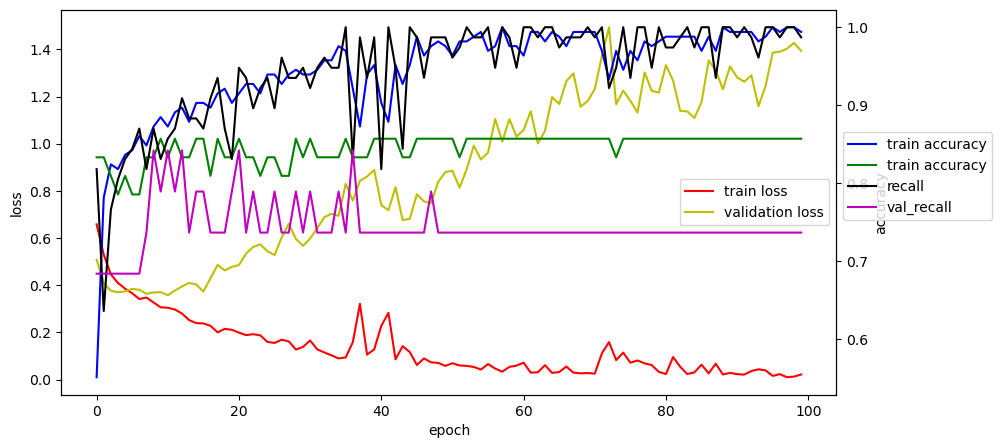

In [84]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['recall_1'], 'k', label='recall')
acc_ax.plot(hist.history['val_recall_1'], 'm', label='val_recall')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

# 6. 모델 사용하기

In [86]:
# 모델 평가
score = model.evaluate(X_test,y_test)
print('model loss:', score[0])
print('model accuracy:', score[1])
print('model recall:', score[2])
print('model precision:', score[3])

3/3 [==============================] - 0s 3ms/step - loss: 1.6884 - accuracy: 0.8315 - recall_1: 0.7750 - precision: 0.8378
model loss: 1.6884335279464722
model accuracy: 0.8314606547355652
model recall: 0.7749999761581421
model precision: 0.837837815284729


In [94]:
# 교차표
y_hat = (model.predict(X_test)>0.5).astype(int)
y_hat
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
print(confusion_matrix(y_test,y_hat))
print('f1 score:', f1_score(y_test,y_hat))

3/3 [==============================] - 0s 3ms/step
[[43  6]
 [ 9 31]]
f1 score: 0.8051948051948051


In [96]:
pd.crosstab(y_test.values.reshape(-1), # 실제값(1차원)
            y_hat.reshape(-1))# 예측값(1차원)

col_0,0,1
row_0,,
0,43,6
1,9,31
